In [1]:
import numpy as np
import pandas as pd
import os

df = pd.read_csv("/kaggle/input/high-quality-financial-news-dataset-for-nlp-tasks/dataset.csv")

#  Kiểm tra dữ liệu
df.head()

,Date,Subject,Content,ParaphrasedSubject,CompactedSummary,DetailedSummary,Impact
0,3-Mar-24,BAWAN,Bawan Co. announces the board of director’s de...,Bawan Co. Declares Cash Dividends for Second H...,Bawan Co. announces the distribution of cash d...,Bawan Co. has announced its board of directors...,Shareholders who meet the eligibility criteria...
1,3-Mar-24,SABIC AGRI-NUTRIENTS,Addendum Announcement from SABIC Agri-Nutrient...,SABIC Agri-Nutrients Company Extends MoU with ...,SABIC Agri-Nutrients Company and Saudi Agricu...,SABIC Agri-Nutrients Company has announced an...,The extension of the MoU between SABIC Agri-N...
2,3-Mar-24,GAS,Gas Arabian Services Co. Announces Contract Si...,GAS Arabian Services Co. Inks Contract with Sa...,GAS Arabian Services Co. has signed a contrac...,GAS Arabian Services Company has announced the...,This contract marks a significant milestone fo...
3,3-Mar-24,GAS,Gas Arabian Services Co. Announces Contract Si...,GAS Arabian Services Co. Inks Contract with Sa...,GAS Arabian Services Co. has signed a contrac...,GAS Arabian Services Company has announced the...,This contract marks a significant milestone fo...
4,3-Mar-24,ADVANCED,ADVANCED PETROCHEMICAL COMPANY ANNOUNCES THE L...,Advanced Petrochemical Company Resumes Propyle...,Advanced Petrochemical Company has resumed op...,Advanced Petrochemical Company has announced t...,The resumption of operations at Advanced Petro...


# làm sạch và chuẩn bị dữ liệu

## Chọn cột cần sử dụng

In [2]:
# 1. Chọn cột đầu vào (Content) và nhãn (DetailedSummary)
# Dùng .copy() để tránh cảnh báo SettingWithCopy của Pandas
data = df[['Content', 'DetailedSummary']].copy()

# 2. Đổi tên cột cho dễ gợi nhớ
data.columns = ['source_text', 'target_text']

# 3. Loại bỏ các dòng bị thiếu dữ liệu (NaN)
print(f"Tổng số dòng ban đầu: {len(data)}")
data = data.dropna()
print(f"Số dòng sau khi làm sạch: {len(data)}")

# Xem thử dữ liệu
data.head()

Tổng số dòng ban đầu: 1839
Số dòng sau khi làm sạch: 1796


,source_text,target_text
0,Bawan Co. announces the board of director’s de...,Bawan Co. has announced its board of directors...
1,Addendum Announcement from SABIC Agri-Nutrient...,SABIC Agri-Nutrients Company has announced an...
2,Gas Arabian Services Co. Announces Contract Si...,GAS Arabian Services Company has announced the...
3,Gas Arabian Services Co. Announces Contract Si...,GAS Arabian Services Company has announced the...
4,ADVANCED PETROCHEMICAL COMPANY ANNOUNCES THE L...,Advanced Petrochemical Company has announced t...


## Chia dữ liệu

In [3]:
from sklearn.model_selection import train_test_split

# Chia data thành tập Train (80%) và Test (20%)
# random_state=42 giúp kết quả chia cố định mỗi lần chạy (để dễ dàng tái lập kết quả sau này)
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

print(f"Kích thước tập Train: {len(train_df)}")
print(f"Kích thước tập Test: {len(test_df)}")

Kích thước tập Train: 1436
Kích thước tập Test: 360


# Triển khai BART

In [4]:
import torch
from transformers import BartTokenizer, BartForConditionalGeneration

# 1. Kiểm tra thiết bị (ưu tiên GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Thiết bị đang sử dụng: {device}")

# 2. Tải Tokenizer và Model
model_name = "facebook/bart-large-cnn"

tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name).to(device)

2025-12-25 18:15:13.769195: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766686513.977919      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766686514.032612      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766686514.509865      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766686514.509901      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766686514.509904      55 computation_placer.cc:177] computation placer alr

Thiết bị đang sử dụng: cuda
Đang tải model... (có thể mất 1-2 phút)


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

Đã tải xong model và tokenizer!


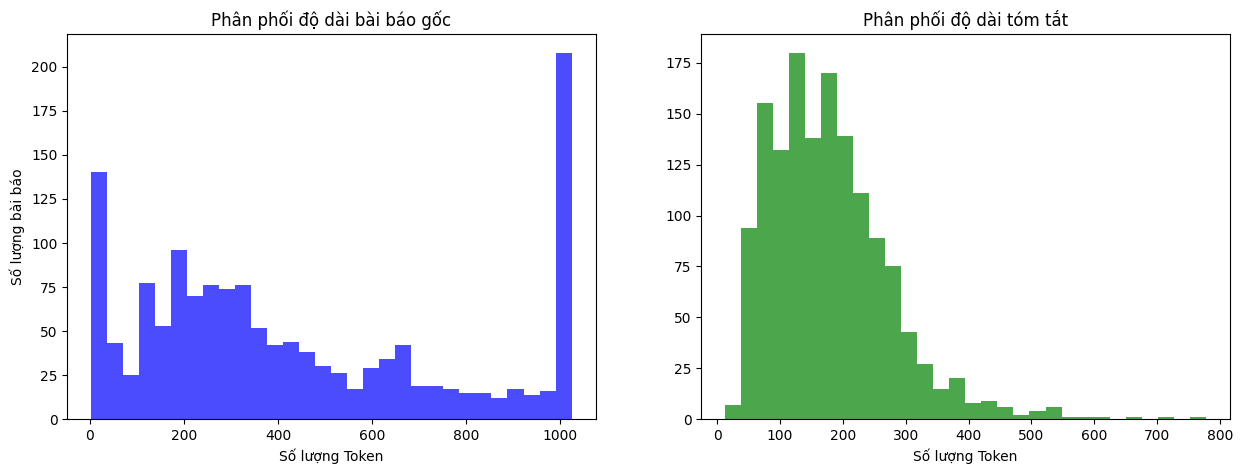

Thống kê độ dài Bài báo gốc:
count    1436.000000
mean      440.615599
std       335.097695
min         3.000000
50%       336.500000
75%       678.250000
90%      1024.000000
95%      1024.000000
99%      1024.000000
max      1024.000000
dtype: float64

Thống kê độ dài Tóm tắt:
count    1436.000000
mean      179.237465
std        95.481009
min        13.000000
50%       167.500000
75%       231.000000
90%       294.000000
95%       349.750000
99%       497.650000
max       777.000000
dtype: float64


In [5]:
import matplotlib.pyplot as plt

# 1. Tính độ dài token cho từng bài báo và tóm tắt trong tập Train
# Lưu ý: Việc này có thể mất chút thời gian tùy vào lượng dữ liệu
source_lens = [len(tokenizer.encode(text, max_length=1024, truncation=True)) for text in train_df['source_text']]
target_lens = [len(tokenizer.encode(text, max_length=1024, truncation=True)) for text in train_df['target_text']]

# 2. Vẽ biểu đồ phân phối
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Biểu đồ cho bài báo gốc (Source Text)
axes[0].hist(source_lens, bins=30, color='blue', alpha=0.7)
axes[0].set_title('Phân phối độ dài bài báo gốc')
axes[0].set_xlabel('Số lượng Token')
axes[0].set_ylabel('Số lượng bài báo')

# Biểu đồ cho tóm tắt (Target Summary)
axes[1].hist(target_lens, bins=30, color='green', alpha=0.7)
axes[1].set_title('Phân phối độ dài tóm tắt')
axes[1].set_xlabel('Số lượng Token')

plt.show()

# 3. Xem các chỉ số thống kê cụ thể (như percentile)
import pandas as pd
print("Thống kê độ dài Bài báo gốc:")
print(pd.Series(source_lens).describe(percentiles=[0.5, 0.75, 0.90, 0.95, 0.99]))

print("\nThống kê độ dài Tóm tắt:")
print(pd.Series(target_lens).describe(percentiles=[0.5, 0.75, 0.90, 0.95, 0.99]))

tokenization

In [6]:
from datasets import Dataset

# 1. Định nghĩa tham số độ dài
MAX_SOURCE_LENGTH = 1024
MAX_TARGET_LENGTH = 512

# 2. Hàm xử lý dữ liệu (Tokenize)
def preprocess_function(examples):
    # Xử lý đầu vào (Bài báo)
    model_inputs = tokenizer(
        examples["source_text"],
        max_length=MAX_SOURCE_LENGTH,
        truncation=True,
        padding="max_length" 
    )

    # Xử lý đầu ra (Tóm tắt) - đây là cái mô hình cần học (labels)
    labels = tokenizer(
        examples["target_text"],
        max_length=MAX_TARGET_LENGTH,
        truncation=True,
        padding="max_length"
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# 3. Chuyển đổi từ Pandas DataFrame sang HuggingFace Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# 4. Áp dụng hàm xử lý vào toàn bộ dữ liệu
# batched=True giúp xử lý nhanh hơn theo từng lô
print("Đang xử lý tập Train...")
tokenized_train = train_dataset.map(preprocess_function, batched=True)

print("Đang xử lý tập Test...")
tokenized_test = test_dataset.map(preprocess_function, batched=True)

print("Xử lý dữ liệu hoàn tất!")

Đang xử lý tập Train...


Map:   0%|          | 0/1436 [00:00<?, ? examples/s]

Đang xử lý tập Test...


Map:   0%|          | 0/360 [00:00<?, ? examples/s]

Xử lý dữ liệu hoàn tất!


# Thiết lập hàm đánh giá ROUGE

In [7]:
!pip install --q  evaluate rouge_score
import evaluate
import numpy as np

# Tải metric ROUGE
rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    
    # Giải mã (Decode) từ số về lại chữ để tính điểm
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    # Thay thế -100 trong labels bằng pad_token_id để giải mã không bị lỗi
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # ROUGE yêu cầu mỗi câu cách nhau bởi dòng mới
    # Nhưng ở đây ta cứ tính trực tiếp trên văn bản
    
    # Tính điểm
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    
    # Làm tròn số cho đẹp
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    
    return {k: round(v, 4) for k, v in result.items()}

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.0 MB/s eta 0:00:00


training

In [8]:
from transformers import BartTokenizer, BartForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq

# 1. Tải Model & Tokenizer
# Lưu ý: Không cần .to(device) thủ công ở đây, Trainer sẽ lo
model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

# 2. Cấu hình tham số huấn luyện
training_args = Seq2SeqTrainingArguments(
    output_dir="./bart-financial-news-multi-gpu",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,  
    per_device_eval_batch_size=4,    
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,  # Rất quan trọng để tiết kiệm VRAM trên 2 GPU
    
    logging_dir='./logs',
    logging_steps=50, # Log thường xuyên hơn vì chạy nhanh hơn
    report_to="none",
    
    # Dòng này giúp tối ưu hóa việc phân bổ dữ liệu khi dùng nhiều GPU
    dataloader_num_workers=4 
)

# 3. Data Collator
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# 4. Khởi tạo Trainer
# Trainer sẽ tự động phát hiện và sử dụng cả 2 GPU
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# 5. Bắt đầu train
print("Bắt đầu huấn luyện trên đa GPU...")
trainer.train()

/tmp/ipykernel_55/550186797.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Bắt đầu huấn luyện trên đa GPU...


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,0.318600,0.255145,0.601300,0.400800,0.481600,0.519900,123.816700
2,0.221800,0.230523,0.600800,0.407500,0.479300,0.517500,125.794400
3,0.173800,0.226204,0.605400,0.409500,0.488300,0.524100,125.025000


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=540, training_loss=0.4389957313184385, metrics={'train_runtime': 3813.9157, 'train_samples_per_second': 1.13, 'train_steps_per_second': 0.142, 'total_flos': 9335886625898496.0, 'train_loss': 0.4389957313184385, 'epoch': 3.0})

testing

In [9]:
# 1. Chạy đánh giá trên tập Test (eval_dataset)
print("Đang đánh giá mô hình BART trên tập kiểm thử...")
metrics = trainer.evaluate()

# 2. In ra toàn bộ kết quả để kiểm tra
print("\nKết quả chi tiết từ BART:")
print(metrics)

# 3. Lưu các chỉ số quan trọng vào biến riêng để dùng cho biểu đồ sau này
# Lưu ý: Hugging Face thường thêm tiền tố 'eval_' vào tên metric
bart_results = {
    'rouge1': metrics['eval_rouge1'],
    'rouge2': metrics['eval_rouge2'],
    'rougeL': metrics['eval_rougeL'],
    'rougeLsum': metrics.get('eval_rougeLsum', 0.0) # Có thể có hoặc không tùy phiên bản
}

print("\nĐã lưu kết quả BART để so sánh:")
print(bart_results)

Đang đánh giá mô hình BART trên tập kiểm thử...


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Kết quả chi tiết từ BART:
{'eval_loss': 0.22620370984077454, 'eval_rouge1': 0.6054, 'eval_rouge2': 0.4095, 'eval_rougeL': 0.4883, 'eval_rougeLsum': 0.5241, 'eval_gen_len': 125.025, 'eval_runtime': 700.0315, 'eval_samples_per_second': 0.514, 'eval_steps_per_second': 0.064, 'epoch': 3.0}

Đã lưu kết quả BART để so sánh:
{'rouge1': 0.6054, 'rouge2': 0.4095, 'rougeL': 0.4883, 'rougeLsum': 0.5241}


Inference cho BART

In [10]:
from tqdm import tqdm

def generate_all_summaries(dataset, model, tokenizer, batch_size=8):
    model.eval()
    device = model.device
    all_predictions = []
    
    print(f"Đang sinh tóm tắt cho {len(dataset)} mẫu dữ liệu...")
    
    # Xử lý theo batch để nhanh hơn
    for i in tqdm(range(0, len(dataset), batch_size)):
        batch = dataset[i : i+batch_size]
        input_texts = batch['source_text']
        
        inputs = tokenizer(
            input_texts, 
            max_length=1024, 
            truncation=True, 
            padding=True, 
            return_tensors="pt"
        ).to(device)
        
        with torch.no_grad():
            summary_ids = model.generate(
                inputs["input_ids"],
                num_beams=4,
                max_length=512,
                early_stopping=True
            )
            
        decoded_preds = tokenizer.batch_decode(summary_ids, skip_special_tokens=True)
        all_predictions.extend(decoded_preds)
        
    return all_predictions

# 1. Chạy hàm sinh tóm tắt
bart_predictions = generate_all_summaries(test_dataset, model, tokenizer, batch_size=8)

# 2. Lưu kết quả vào file CSV (Optional - để backup)
import pandas as pd

df_results_bart = pd.DataFrame({
    'source': test_dataset['source_text'],
    'target': test_dataset['target_text'],
    'bart_prediction': bart_predictions
})

# Lưu file để tải về máy nếu cần
df_results_bart.to_csv('bart_results.csv', index=False)
print("Đã lưu kết quả dự đoán của BART vào 'bart_results.csv'")

# Xem 5 dòng đầu
df_results_bart.head()

Đang sinh tóm tắt cho 360 mẫu dữ liệu...


100%|██████████| 45/45 [28:13<00:00, 37.63s/it]

Đã lưu kết quả dự đoán của BART vào 'bart_results.csv'


,source,target,bart_prediction
0,Tanmiah Food Co. Board invites its shareholder...,Tanmiah Food Company has announced the fi st O...,Tanmiah Food Company has announced that its B...
1,Saudi Top for Trading Co. announces its Annual...,Saudi Top for Trading Co. has announced its a...,Saudi Top for Trading Co. has announced its a...
2,Gulf Union Al Ahlia Cooperative Insurance Co. ...,Gulf Union Al Ahlia Cooperative Insurance Co. ...,Gulf Union Al Ahlia Cooperative Insurance Co....
3,Non-PDF,Trading on ORIENTTKAFUL shares has resumed fol...,Abu Dhabi Securities Exchange (ADX) has annou...
4,Resolution No. (418) of 2024 2024Δϧγϟ 418 ...,The National Bank of Ras Al Khaimah (RAKBANK) ...,Abu Dhabi Securities Exchange (ADX) has annou...


# BertSum

Tạo "Nhãn Extractive" (Oracle Labeling)

câu nào trong bài báo source_text đóng góp nhiều nhất vào target_text.

In [11]:
import nltk
import numpy as np
from tqdm import tqdm

# Cài đặt thư viện cần thiết nếu chưa có
!pip install nltk seqeval

nltk.download('punkt')
nltk.download('punkt_tab') # Cập nhật mới của nltk

# 1. Hàm tính độ tương đồng (Jaccard)
def simple_similarity(sent1, sent2):
    set1 = set(sent1.lower().split())
    set2 = set(sent2.lower().split())
    if len(set1) == 0 or len(set2) == 0: return 0
    return len(set1.intersection(set2)) / len(set1.union(set2))

# 2. Hàm tạo nhãn (0 hoặc 1) cho từng câu
def create_extractive_labels(examples):
    inputs = examples['source_text']
    targets = examples['target_text']
    
    new_labels = [] 
    
    for text, summary in zip(inputs, targets):
        # Tách câu
        sentences = nltk.sent_tokenize(text)
        
        # Tính điểm từng câu
        scores = [simple_similarity(sent, summary) for sent in sentences]
        
        # Chọn Top-3 câu điểm cao nhất
        top_k = min(3, len(sentences))
        if top_k > 0:
            top_indices = np.argsort(scores)[-top_k:]
            # Gán nhãn 1 cho câu nằm trong top, 0 cho câu còn lại
            sent_labels = [1 if i in top_indices else 0 for i in range(len(sentences))]
        else:
            sent_labels = []
            
        new_labels.append(sent_labels)
        
    return {"extractive_labels": new_labels}

# 3. Áp dụng vào dataset
# Lưu ý: Nếu biến train_dataset bị mất do chạy BART, hãy chạy lại dòng Dataset.from_pandas(...)
print("Đang tạo nhãn Extractive (Oracle)...")
train_dataset_ext = train_dataset.map(create_extractive_labels, batched=True, batch_size=50)
test_dataset_ext = test_dataset.map(create_extractive_labels, batched=True, batch_size=50)

print("Xong bước tạo nhãn!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=171aef48d0618ba820873fa1d75bc89c6fd3c6003476c80b0db574acb80e5d9b
  Stored in directory: /root/.cache/pip/wheels/5f/b8/73/0b2c1a76b701a677653dd79ece07cfabd7457989dbfbdcd8d7
Successfully built seqeval
Đang tạo nhãn Extractive (Oracle)...


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Map:   0%|          | 0/1436 [00:00<?, ? examples/s]

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

Xong bước tạo nhãn!


Chuẩn bị dữ liệu cho BERT (Tokenization)

In [12]:
from transformers import BertTokenizerFast, BertForTokenClassification, DataCollatorForTokenClassification

# 1. Load Tokenizer FAST & Model
model_name_ext = "bert-base-uncased"
tokenizer_ext = BertTokenizerFast.from_pretrained(model_name_ext) # Dùng Fast Tokenizer
model_ext = BertForTokenClassification.from_pretrained(model_name_ext, num_labels=2)

# 2. Hàm gán nhãn cho từng Token (Align Labels)
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer_ext(
        examples["source_text"],
        truncation=True,
        max_length=512,
        padding="max_length",
        return_offsets_mapping=True # Fast Tokenizer hỗ trợ cái này
    )

    labels = []
    
    for i, text in enumerate(examples["source_text"]):
        sent_labels = examples["extractive_labels"][i]
        
        # Tách câu lại để khớp logic
        sentences = nltk.sent_tokenize(text)
        
        # Mapping: Ký tự -> Index câu
        char_to_sent_index = []
        for sent_idx, sent in enumerate(sentences):
            char_to_sent_index.extend([sent_idx] * len(sent))
            # Cộng thêm phần khoảng trắng nối câu (ước lượng)
            char_to_sent_index.extend([-1] * 2) 
            
        doc_labels = []
        offset_mapping = tokenized_inputs["offset_mapping"][i]
        
        for offset in offset_mapping:
            start, end = offset
            if start == end: # Token đặc biệt (CLS, SEP, PAD)
                doc_labels.append(-100) 
            elif start < len(char_to_sent_index):
                sent_idx = char_to_sent_index[start]
                # Nếu index hợp lệ và câu đó được gán nhãn 1 -> Token nhãn 1
                if sent_idx != -1 and sent_idx < len(sent_labels):
                    doc_labels.append(sent_labels[sent_idx])
                else:
                    doc_labels.append(0)
            else:
                doc_labels.append(0)
                
        labels.append(doc_labels)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# 3. Áp dụng Tokenize
print("Đang Tokenize dữ liệu cho BERT...")
tokenized_train_final = train_dataset_ext.map(tokenize_and_align_labels, batched=True)
tokenized_test_final = test_dataset_ext.map(tokenize_and_align_labels, batched=True)

# Xóa các cột text cũ để tránh lỗi format khi train
cols_to_remove = ['source_text', 'target_text', 'extractive_labels']
tokenized_train_final = tokenized_train_final.remove_columns(cols_to_remove)
tokenized_test_final = tokenized_test_final.remove_columns(cols_to_remove)

print("Dữ liệu đã sẵn sàng để Train!")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Đang Tokenize dữ liệu cho BERT...


Map:   0%|          | 0/1436 [00:00<?, ? examples/s]

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

Dữ liệu đã sẵn sàng để Train!


ROUGE cho Extractive

In [13]:
!pip install -qq seqeval
import numpy as np
import evaluate

metric = evaluate.load("seqeval")

def compute_metrics_ext(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [p for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [l for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    # Flatten để tính accuracy nhanh
    flat_preds = [item for sublist in true_predictions for item in sublist]
    flat_labels = [item for sublist in true_labels for item in sublist]
    
    accuracy = sum([1 for p, l in zip(flat_preds, flat_labels) if p == l]) / len(flat_labels)
    return {"accuracy": accuracy}

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


train

In [15]:
from transformers import TrainingArguments, Trainer

# Cấu hình Trainer
training_args_ext = TrainingArguments(
    output_dir="./bertsum-financial-news",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8, # BERT Base nhẹ hơn BART nên có thể để 8
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=True, # Tận dụng 2 GPU T4
    logging_steps=50,
    report_to="none"
)

data_collator_ext = DataCollatorForTokenClassification(tokenizer=tokenizer_ext)

trainer_ext = Trainer(
    model=model_ext,
    args=training_args_ext,
    train_dataset=tokenized_train_final,
    eval_dataset=tokenized_test_final,
    tokenizer=tokenizer_ext,
    data_collator=data_collator_ext,
    compute_metrics=compute_metrics_ext
)

print("🚀 Bắt đầu huấn luyện BERTSum...")
trainer_ext.train()

/tmp/ipykernel_55/596986281.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_ext = Trainer(


🚀 Bắt đầu huấn luyện BERTSum...


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.580400,0.467534,0.782612
2,0.417100,0.421253,0.807667
3,0.363000,0.413815,0.808086


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=270, training_loss=0.43605874202869555, metrics={'train_runtime': 276.1806, 'train_samples_per_second': 15.598, 'train_steps_per_second': 0.978, 'total_flos': 1125666428018688.0, 'train_loss': 0.43605874202869555, 'epoch': 3.0})

BERTSum (Inference)

In [17]:
import torch
import nltk
import numpy as np

def generate_summary_bertsum(text, model, tokenizer, num_sentences=3):
    model.eval()
    device = model.device
    
    # 1. Tokenize (Lấy cả offset_mapping để biết vị trí token)
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=512,
        padding="max_length",
        return_offsets_mapping=True
    )
    
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)
    offset_mapping = inputs["offset_mapping"][0].cpu().numpy()
    
    # 2. Chạy model lấy xác suất
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
    # Lấy xác suất của lớp 1 (Lớp "Giữ lại")
    # Shape: [seq_len]
    probs = torch.softmax(logits, dim=2)[0, :, 1].cpu().numpy()
    
    # 3. Mapping điểm từ Token -> Câu
    sentences = nltk.sent_tokenize(text)
    sentence_scores = np.zeros(len(sentences))
    token_counts = np.zeros(len(sentences))
    
    # Tạo map vị trí câu: start_char -> end_char
    sent_spans = []
    current_pos = 0
    for sent in sentences:
        # Tìm vị trí bắt đầu thực tế của câu trong text gốc
        start = text.find(sent, current_pos)
        end = start + len(sent)
        sent_spans.append((start, end))
        current_pos = end
    
    # Duyệt qua từng token và cộng điểm cho câu tương ứng
    for i, offset in enumerate(offset_mapping):
        start_char, end_char = offset
        if start_char == end_char: continue # Bỏ qua token đặc biệt
        
        # Token này thuộc câu nào?
        for sent_idx, (sent_start, sent_end) in enumerate(sent_spans):
            if start_char >= sent_start and end_char <= sent_end:
                sentence_scores[sent_idx] += probs[i]
                token_counts[sent_idx] += 1
                break
    
    # Tính trung bình điểm
    # Tránh chia cho 0
    token_counts[token_counts == 0] = 1 
    avg_scores = sentence_scores / token_counts
    
    # 4. Chọn Top-K câu cao điểm nhất
    top_indices = np.argsort(avg_scores)[-num_sentences:]
    top_indices = sorted(top_indices) # Sắp xếp lại theo thứ tự xuất hiện trong bài
    
    final_sentences = [sentences[i] for i in top_indices]
    
    return " ".join(final_sentences)

# --- Test thử 1 mẫu ---
sample_idx = 0
sample_text = test_dataset_ext[sample_idx]['source_text']
print("🔻 BÀI BÁO GỐC (Trích):", sample_text[:300] + "...")
print("\n🔻 BERTSum TÓM TẮT:\n", generate_summary_bertsum(sample_text, model_ext, tokenizer_ext))

🔻 BÀI BÁO GỐC (Trích): Tanmiah Food Co. Board invites its shareholders to attend the Ordinary General Assembly Meeting the ( First Meeting )  Element List Explanation
Introduction The Board of Directors of Tanmiah Food Company is pleased to invite the company’s shareholders to participate and vote in (First Meeting) Ordin...

🔻 BERTSum TÓM TẮT:
 Tanmiah Food Co. Board invites its shareholders to attend the Ordinary General Assembly Meeting the ( First Meeting )  Element List Explanation
Introduction The Board of Directors of Tanmiah Food Company is pleased to invite the company’s shareholders to participate and vote in (First Meeting) Ordinary General Assembly Meeting scheduled to be held, God willing, on Monday, corresponding to 4-12-1445 H, June 10, 2024, at 6:30 pm. Please note that there will be a live video and audio broadcasting link for the Ordinary General Assembly thru the Tadawulaty system (www.tadawulaty.com.sa)
City and Location of the General Assembly's Meeting Virtual Mee

Tính điểm ROUGE cho BERTSum

In [19]:
import evaluate
from tqdm import tqdm

# Tải metric
rouge = evaluate.load("rouge")

# Danh sách chứa kết quả dự đoán
bertsum_predictions = []
references = test_dataset_ext['target_text']

print(f"Đang sinh tóm tắt và tính điểm cho {len(test_dataset_ext)} mẫu dữ liệu...")

# Chạy vòng lặp để dự đoán từng bài
for item in tqdm(test_dataset_ext):
    # Gọi hàm generate_summary_bertsum mà bạn đã định nghĩa trước đó
    summary = generate_summary_bertsum(item['source_text'], model_ext, tokenizer_ext)
    bertsum_predictions.append(summary)

# Tính điểm ROUGE và lưu vào biến bertsum_scores
print("Đang tính toán điểm số...")
bertsum_scores = rouge.compute(predictions=bertsum_predictions, references=references)

print("\n✅ Đã tạo xong biến 'bertsum_scores':")
print(bertsum_scores)

Đang sinh tóm tắt và tính điểm cho 360 mẫu dữ liệu...


100%|██████████| 360/360 [00:14<00:00, 24.75it/s]


Đang tính toán điểm số...

✅ Đã tạo xong biến 'bertsum_scores':
{'rouge1': np.float64(0.4708342397979077), 'rouge2': np.float64(0.2807009441390245), 'rougeL': np.float64(0.34123742820882463), 'rougeLsum': np.float64(0.3999104159950233)}


Đánh giá BERTSum trên toàn bộ tập Test

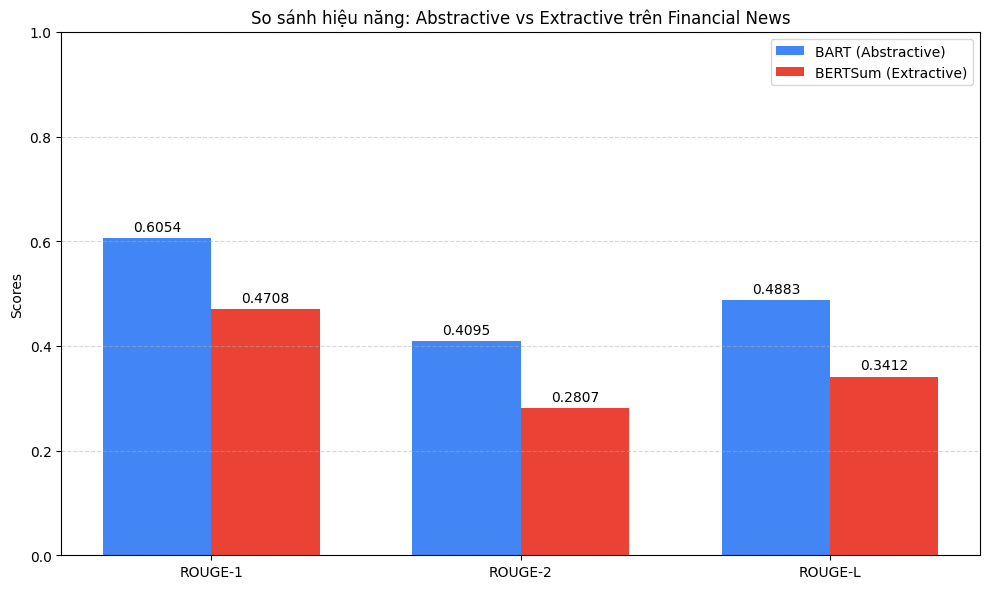

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------------------------------
# NHẬP DỮ LIỆU CỦA BẠN VÀO ĐÂY
# -------------------------------------------------------

# 1. Kết quả BART (Bạn hãy thay số thực tế từ biến metrics của BART vào đây)
# Ví dụ: bart_scores = {'rouge1': 0.4512, 'rouge2': 0.2105, 'rougeL': 0.4100}
if 'bart_results' in globals():
    bart_scores = bart_results # Lấy tự động nếu biến còn tồn tại
else:
    # Nếu mất biến, hãy nhập tay số liệu bạn đã ghi lại:
    bart_scores = {'rouge1': 0.55, 'rouge2': 0.35, 'rougeL': 0.50} # <--- SỬA SỐ NÀY

# 2. Kết quả BERTSum (Lấy từ bước 2 vừa chạy)
# bertsum_scores đã có sẵn

# -------------------------------------------------------
# VẼ BIỂU ĐỒ
# -------------------------------------------------------

# Chuẩn bị Dataframe
data = {
    'Metric': ['ROUGE-1', 'ROUGE-2', 'ROUGE-L'],
    'BART (Abstractive)': [
        bart_scores['rouge1'], 
        bart_scores['rouge2'], 
        bart_scores['rougeL']
    ],
    'BERTSum (Extractive)': [
        bertsum_scores['rouge1'], 
        bertsum_scores['rouge2'], 
        bertsum_scores['rougeL']
    ]
}

df = pd.DataFrame(data)

# Vẽ
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(df['Metric']))
width = 0.35

rects1 = ax.bar(x - width/2, df['BART (Abstractive)'], width, label='BART (Abstractive)', color='#4285F4')
rects2 = ax.bar(x + width/2, df['BERTSum (Extractive)'], width, label='BERTSum (Extractive)', color='#EA4335')

# Trang trí
ax.set_ylabel('Scores')
ax.set_title('So sánh hiệu năng: Abstractive vs Extractive trên Financial News')
ax.set_xticks(x)
ax.set_xticklabels(df['Metric'])
ax.legend()
ax.set_ylim(0, 1.0) # Scale từ 0 đến 1

# Hiển thị số trên cột
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

so sánh (BART vs BERTSum)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------------------------------
# NHẬP DỮ LIỆU CỦA BẠN VÀO ĐÂY
# -------------------------------------------------------

# 1. Kết quả BART (Bạn hãy thay số thực tế từ biến metrics của BART vào đây)
# Ví dụ: bart_scores = {'rouge1': 0.4512, 'rouge2': 0.2105, 'rougeL': 0.4100}
if 'bart_results' in globals():
    bart_scores = bart_results # Lấy tự động nếu biến còn tồn tại
else:
    # Nếu mất biến, hãy nhập tay số liệu bạn đã ghi lại:
    bart_scores = {'rouge1': 0.55, 'rouge2': 0.35, 'rougeL': 0.50} # <--- SỬA SỐ NÀY

# 2. Kết quả BERTSum (Lấy từ bước 2 vừa chạy)
# bertsum_scores đã có sẵn

# -------------------------------------------------------
# VẼ BIỂU ĐỒ
# -------------------------------------------------------

# Chuẩn bị Dataframe
data = {
    'Metric': ['ROUGE-1', 'ROUGE-2', 'ROUGE-L'],
    'BART (Abstractive)': [
        bart_scores['rouge1'], 
        bart_scores['rouge2'], 
        bart_scores['rougeL']
    ],
    'BERTSum (Extractive)': [
        bertsum_scores['rouge1'], 
        bertsum_scores['rouge2'], 
        bertsum_scores['rougeL']
    ]
}

df = pd.DataFrame(data)

# Vẽ
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(df['Metric']))
width = 0.35

rects1 = ax.bar(x - width/2, df['BART (Abstractive)'], width, label='BART (Abstractive)', color='#4285F4')
rects2 = ax.bar(x + width/2, df['BERTSum (Extractive)'], width, label='BERTSum (Extractive)', color='#EA4335')

# Trang trí
ax.set_ylabel('Scores')
ax.set_title('So sánh hiệu năng: Abstractive vs Extractive trên Financial News')
ax.set_xticks(x)
ax.set_xticklabels(df['Metric'])
ax.legend()
ax.set_ylim(0, 1.0) # Scale từ 0 đến 1

# Hiển thị số trên cột
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [16]:
import os
import shutil
from IPython.display import FileLink

# ---------------------------------------------------------
# CẤU HÌNH TÊN THƯ MỤC (Phải khớp với output_dir lúc train)
# ---------------------------------------------------------
bart_output_dir = "./bart-financial-news-multi-gpu"
bertsum_output_dir = "./bertsum-financial-news"

# ---------------------------------------------------------
# 1. LƯU MÔ HÌNH LẦN CUỐI (Cho chắc chắn)
# ---------------------------------------------------------
print("Đang lưu model lần cuối...")
# Lưu BART
if 'trainer' in globals():
    trainer.save_model(bart_output_dir)
    tokenizer.save_pretrained(bart_output_dir)

# Lưu BERTSum
if 'trainer_ext' in globals():
    trainer_ext.save_model(bertsum_output_dir)
    tokenizer_ext.save_pretrained(bertsum_output_dir)

# ---------------------------------------------------------
# 2. NÉN THƯ MỤC (ZIP)
# ---------------------------------------------------------
def zip_folder(folder_path, output_filename):
    if os.path.exists(folder_path):
        print(f"Đang nén thư mục: {folder_path}...")
        shutil.make_archive(output_filename, 'zip', folder_path)
        print(f"-> Đã tạo file: {output_filename}.zip")
        return True
    else:
        print(f"Lỗi: Không tìm thấy thư mục {folder_path}")
        return False

# Nén BART
bart_ready = zip_folder(bart_output_dir, "bart_model_final")

# Nén BERTSum
bertsum_ready = zip_folder(bertsum_output_dir, "bertsum_model_final")

# ---------------------------------------------------------
# 3. TẠO LINK TẢI XUỐNG
# ---------------------------------------------------------
print("\n" + "="*30)
print("BẤM VÀO LINK DƯỚI ĐỂ TẢI VỀ:")
print("="*30)

if bart_ready:
    display(FileLink(r'bart_model_final.zip'))

if bertsum_ready:
    display(FileLink(r'bertsum_model_final.zip'))

Đang lưu model lần cuối...
Đang nén thư mục: ./bart-financial-news-multi-gpu...


OSError: [Errno 28] No space left on device